In [1]:
import os
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('white', {'xtick.bottom': True, 'ytick.left': True})
sns.set_context('notebook', font_scale=2)

In [66]:
# color scheme for figures
import visual_behavior.ophys.response_analysis.utilities as ut
colors = ut.get_colors_for_image_sets()

In [3]:
experiment_dir = '/media/brian/Seagate Portable Drive/brianhhu/data/visual_behavior_pilot_manuscript_initial_submission/'
model_dir = '/home/brian/data/stsp_final/noise_std_0.5_pos_weight_5_l2_pen_0.001_patience_5/RESULT/'

In [4]:
manifest = pd.read_csv(os.path.join(experiment_dir,'visual_behavior_data_manifest.csv'))

In [5]:
selected_data = manifest[(manifest.cre_line=='Slc17a7-IRES2-Cre')&  # Vip-IRES-Cre
                         (manifest.session_type=='behavior_session_A')] #&  # behavior_session_B, C, D
#                          (manifest.targeted_structure=='VISp')]  # VISp
selected_data

,experiment_id,experiment_container_id,targeted_structure,imaging_depth,cre_line,reporter_line,full_genotype,session_type,donor_id,specimen_id,experiment_date
8,639253368,639001089,VISp,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_A,334310,599659785,9/28/2017 14:14
12,661423848,661409179,VISal,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_A,355469,643316601,2/6/2018 15:03
16,670396087,670266085,VISp,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_A,355471,644831080,3/6/2018 13:37
28,692342909,692315205,VISal,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_A,369320,656813113,4/30/2018 16:09
40,729951441,729705760,VISal,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_A,382897,679238912,8/3/2018 10:11
44,715228642,715094648,VISal,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_A,384942,687987489,6/27/2018 13:08
48,720001924,719860866,VISp,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_A,384942,687987489,7/13/2018 14:33
52,719321260,719538773,VISal,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_A,385255,685152008,7/12/2018 10:27
64,754566180,754511300,VISp,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_A,401625,717693518,9/17/2018 15:13
84,768224465,768053094,VISp,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_A,407486,739783701,10/24/2018 14:21


In [6]:
experiment_id = selected_data.experiment_id.values
experiment_id

array([639253368, 661423848, 670396087, 692342909, 729951441, 715228642,
       720001924, 719321260, 754566180, 768224465, 760696146, 774379465,
       673139359])

In [7]:
from visual_behavior.ophys.dataset.visual_behavior_ophys_dataset import VisualBehaviorOphysDataset
from visual_behavior.ophys.response_analysis.response_analysis import ResponseAnalysis 

# PCA/LDA/Isomap Analysis

In [8]:
from sklearn.decomposition import PCA

In [41]:
# create dataframe to track variance explained
ve_total = selected_data.loc[:, ['experiment_id']]

for e in experiment_id:
    dataset= VisualBehaviorOphysDataset(e, cache_dir=experiment_dir)
    analysis = ResponseAnalysis(dataset, use_events=False)  # dff or events?
    
    # get trials and flash dataframe
    fdf = analysis.flash_response_df
    
    fdf['change_time'] = fdf.start_time.values
    fdf = pd.merge(fdf, dataset.all_trials[['change_time', 'initial_image_name', 'change_image_name', 'trial_type']],
                                 on='change_time', how='left')
    
    # filter by engagement
    fdf_select = fdf[fdf.reward_rate>2]
    fdf_select = fdf_select[fdf_select.image_name!='omitted']  # don't use omitted images
    num_cells = len(fdf_select.cell_specimen_id.unique())
    
    # flash responses
    cell_flash = fdf_select.mean_response.values.reshape(-1, num_cells) # num_trials x num_cells
    
    
    ### PCA
    # Do PCA dim reduction
    dim_reduce = PCA(n_components=num_cells, whiten=True)  # whiten here?
    dim_reduce.fit(cell_flash)

    # variance explained by first 2 PCs
    cum_variance = np.cumsum(dim_reduce.explained_variance_ratio_)
    for comp in range(10):
        ve_total.loc[ve_total.experiment_id==e, 'pca'+str(comp+1)] = cum_variance[comp]

loading trial response dataframe
loading flash response dataframe
loading omitted flash response dataframe
loading trial response dataframe
loading flash response dataframe
loading omitted flash response dataframe
loading trial response dataframe
loading flash response dataframe
loading omitted flash response dataframe
loading trial response dataframe
loading flash response dataframe
loading omitted flash response dataframe
loading trial response dataframe
loading flash response dataframe
loading omitted flash response dataframe
loading trial response dataframe
loading flash response dataframe
loading omitted flash response dataframe
loading trial response dataframe
loading flash response dataframe
loading omitted flash response dataframe
loading trial response dataframe
loading flash response dataframe
loading omitted flash response dataframe
loading trial response dataframe
loading flash response dataframe
loading omitted flash response dataframe
loading trial response dataframe
load

In [42]:
ve_total

,experiment_id,targeted_structure,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10
8,639253368,VISp,0.467188,0.568044,0.656276,0.702462,0.732055,0.754637,0.776744,0.793817,0.809080,0.822165
12,661423848,VISal,0.208464,0.367467,0.473311,0.550764,0.608278,0.660529,0.698759,0.732789,0.762302,0.785446
16,670396087,VISp,0.380876,0.496877,0.576418,0.642445,0.700700,0.738710,0.769861,0.797329,0.813650,0.827230
28,692342909,VISal,0.302317,0.483792,0.606414,0.693869,0.729692,0.763111,0.789494,0.812259,0.829445,0.845723
40,729951441,VISal,0.246484,0.368146,0.436110,0.480511,0.523289,0.552302,0.579441,0.598799,0.615940,0.629973
44,715228642,VISal,0.556079,0.808191,0.865715,0.879167,0.891490,0.903050,0.911939,0.918619,0.924740,0.930653
48,720001924,VISp,0.596686,0.661832,0.685816,0.705851,0.721090,0.734466,0.746143,0.756096,0.765536,0.774554
52,719321260,VISal,0.245044,0.351106,0.446555,0.533947,0.593806,0.633918,0.665875,0.695798,0.720644,0.744012
64,754566180,VISp,0.339619,0.537722,0.691235,0.738800,0.772074,0.796543,0.816470,0.834070,0.848403,0.861601
84,768224465,VISp,0.227522,0.362722,0.421849,0.458457,0.491440,0.519973,0.543419,0.563011,0.581975,0.596446


In [43]:
ve_total = pd.melt(ve_total, id_vars=['experiment_id'], value_vars=['pca'+str(i) for i in range(1,11)], var_name='pca_dim', value_name='variance_explained')

In [60]:
# rename column for concatenation below
ve_total['experiment_id'] = 'experiment'
ve_total = ve_total.rename(columns={'experiment_id': 'model'})

# Model results

In [46]:
model_dict = {}
for model in ['STSPNet', 'RNN']:
    model_dict[model] = {}

    for comp in range(1, 11):
        model_dict[model]['pca'+str(comp)] = []

    for seed in range(1,11):
        model_data = pickle.load(open(model_dir+model+'/'+model+'_A_'+str(seed)+'.pkl', 'rb'))

        # Format model data
        data = model_data['input']  # choose either input layer or hidden layer
        num_cells = data.shape[2]

        # Get cell flashes (ignore initial set of flashes)
        cell_flash = data[:, 12::3].reshape(-1, num_cells)

        # remove omitted flashes
        img_model = model_data['image'][:, 12::3].flatten()
        cell_flash = cell_flash[img_model!=8]
                          
        # PCA
        pca = PCA(n_components=num_cells)
        X_pca = pca.fit(cell_flash).transform(cell_flash)
                         
        cum_variance = np.cumsum(pca.explained_variance_ratio_)
        for comp in range(10):
            model_dict[model]['pca'+str(comp+1)].append(cum_variance[comp])
    
    for comp in range(1, 11):
        model_dict[model]['pca'+str(comp)] = np.array(model_dict[model]['pca'+str(comp)])

In [62]:
stspnet_df = pd.DataFrame({'model': 'STPNet', 'pca1': model_dict['STSPNet']['pca1'], 'pca2': model_dict['STSPNet']['pca2'], 'pca3': model_dict['STSPNet']['pca3'], 'pca4': model_dict['STSPNet']['pca4'], 'pca5': model_dict['STSPNet']['pca5'], 'pca6': model_dict['STSPNet']['pca6'], 'pca7': model_dict['STSPNet']['pca7'], 'pca8': model_dict['STSPNet']['pca8'], 'pca9': model_dict['STSPNet']['pca9'], 'pca10': model_dict['STSPNet']['pca10']})
rnn_df = pd.DataFrame({'model': 'RNN', 'pca1': model_dict['RNN']['pca1'], 'pca2': model_dict['RNN']['pca2'], 'pca3': model_dict['RNN']['pca3'], 'pca4': model_dict['RNN']['pca4'], 'pca5': model_dict['RNN']['pca5'], 'pca6': model_dict['RNN']['pca6'], 'pca7': model_dict['RNN']['pca7'], 'pca8': model_dict['RNN']['pca8'], 'pca9': model_dict['RNN']['pca9'], 'pca10': model_dict['RNN']['pca10']})

#melt
stspnet_df = pd.melt(stspnet_df, id_vars=['model'], value_vars=['pca'+str(i) for i in range(1,11)], var_name='pca_dim', value_name='variance_explained')
rnn_df = pd.melt(rnn_df, id_vars=['model'], value_vars=['pca'+str(i) for i in range(1,11)], var_name='pca_dim', value_name='variance_explained')


df_all = pd.concat((ve_total, stspnet_df, rnn_df), ignore_index=True)

In [77]:
sns.set_context({'axes.spines.right': False, 'axes.spines.top': False})

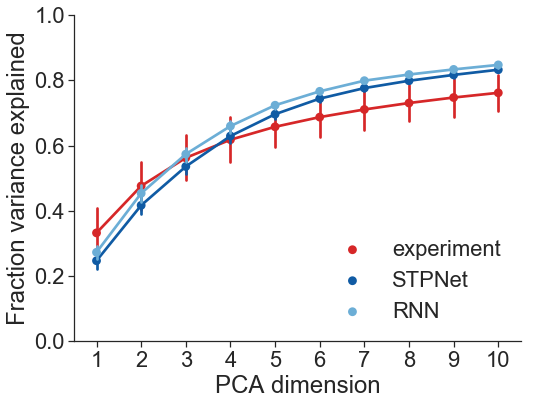

In [79]:
plt.figure(figsize=(8,6))


ax = sns.pointplot(x="pca_dim", y="variance_explained", kind="point", hue="model", palette=[colors[0],colors[1],colors[3]], data=df_all)

ax.set(ylim=(0, 1.0))
ax.set_xlabel('PCA dimension')
ax.set_ylabel('Fraction variance explained')
ax.set_xticklabels([str(i) for i in range(1,11)])
ax.legend(frameon=False, loc='lower right')

plt.savefig('variance_explained.png', dpi=300, bbox_inches='tight')